In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.autonotebook import tqdm
from polar import PolarCode,get_frozen
from reliability_sequence import Reliability_Sequence
from utils import errors_ber,errors_bler
import matplotlib.pyplot as plt
import os

C:\Users\pratyush\AppData\Local\Temp\ipykernel_5820\3055195471.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
n = 4
N = 2**n 
K = 9
snr = -1
batch_size = 1
num_samples = 1000


In [3]:

def create_data(num_samples, batch_size, n, K, snr):
    msg_bits_list = []
    bpsk_list = []
    codeword_list = []
    corrupted_codeword_list = []

    # Loop to generate data samples
    for i in range(num_samples):
        msg_bits = (torch.rand(batch_size, K) > 0.5).float()
        bpsk = 1 - 2 * msg_bits

        polar = PolarCode(n, K, Fr=None, use_cuda=True, hard_decision=True)
        codeword = polar.encode(bpsk)
        corrupted_codewords = polar.channel(codeword, snr)

        msg_bits_list.append(msg_bits.cpu().numpy())
        bpsk_list.append(bpsk.cpu().numpy())
        codeword_list.append(codeword.cpu().numpy())
        corrupted_codeword_list.append(corrupted_codewords.cpu().numpy())

    filename = f"polar_dataset_N{2**n}_K{K}_SNR{snr}_bs{batch_size}.npz"
    np.savez(f"polar_dataset_N{2**n}_K{K}_SNR{snr}_bs{batch_size}.npz", msg_bits=msg_bits_list, corrupted_codeword=corrupted_codeword_list,bpsk = bpsk_list,codeword=codeword_list)
    print(f"Dataset saved as {filename}")
    

In [4]:
create_data(num_samples,batch_size,n,K,snr)

Dataset saved as polar_dataset_N8_K3_SNR1_bs1.npz


In [3]:
df = np.load('data\polar_dataset_N16_K9_SNR-1_bs1.npz')

In [4]:
from tqdm.autonotebook import tqdm
Fr = get_frozen(N, K,rs=Reliability_Sequence)
polar = PolarCode(n, K, Fr = Fr,use_cuda=False,hard_decision=True)
device = 'cpu'
ber_SC_total=0
bler_SC_total=0
x=10000
for bpsk_bits, corrupted_codeword in tqdm(zip(df['bpsk'][:x], df['corrupted_codeword'][:x]),total=len(df['bpsk'][:x])):
    bpsk_tensor = torch.tensor(bpsk_bits, dtype=torch.float32,device=device)
    corrupted_codeword_tensor = torch.tensor(corrupted_codeword, dtype=torch.float32,device=device)

    SC_llrs, decoded_SC_msg_bits = polar.sc_decode_new(corrupted_codeword_tensor, snr=snr)
    ber_SC = errors_ber(bpsk_tensor,decoded_SC_msg_bits.sign()).item()
    bler_SC = errors_bler(bpsk_tensor,decoded_SC_msg_bits.sign()).item()

    ber_SC_total+=ber_SC
    bler_SC_total+=bler_SC

100%|██████████| 1000/1000 [00:14<00:00, 69.40it/s]


In [5]:
decoded_SC_msg_bits, corrupted_codeword_tensor, bpsk_tensor

(tensor([[-1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.]]),
 tensor([[ 0.4047, -0.5330,  3.6527, -2.1431, -0.2792,  1.1791,  1.2796,  0.7252,
          -2.0050,  2.5977,  0.8154,  0.7610, -1.9429,  0.9818,  0.4197,  1.1289]]),
 tensor([[ 1., -1., -1., -1., -1., -1.,  1.,  1.,  1.]]))

In [6]:
ber_SC_total/len(df['msg_bits'][:x]),bler_SC_total/len(df['msg_bits'][:x])

(0.3531111162528396, 0.867)

### LSTM CCI

In [24]:
class LSTMDecoder(nn.Module):
    def __init__(self,N,K,hidden_size,rs):
        super().__init__()
        self.N = N
        self.K = K
        self.hidden_size = hidden_size

        self.frozen_positions = get_frozen(self.N, self.K, rs)
        self.frozen_mask = torch.full((N,), 0, dtype=torch.int8)
        # self.frozen_mask = torch.zeros(N,dtype=torch.bool)
        self.frozen_mask[self.frozen_positions] = 1
        self.lstms = nn.ModuleList([
            nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=1, batch_first=True)
            for _ in range(N)
        ])
        self.fcs= nn.ModuleList([
            nn.Linear(hidden_size, 1) for _ in range(N)
        ])
    
    def forward(self,corrupted_codeword):
        batch_size = corrupted_codeword.size(0)
        device = corrupted_codeword.device
        x = corrupted_codeword.unsqueeze(-1) if corrupted_codeword.dim() == 2 else corrupted_codeword

        h0 = [torch.zeros(1, batch_size, self.hidden_size, device=device) for _ in range(self.N)]
        c0 = [torch.zeros(1, batch_size, self.hidden_size, device=device) for _ in range(self.N)]

        decoded_outputs = []
        for i in range(self.N):
            output, (h0[i], c0[i]) = self.lstms[i](x, (h0[i], c0[i]))

            decoded_bits = self.fcs[i](output).squeeze(-1)
            decoded_outputs.append(decoded_bits)
            x = corrupted_codeword + (self.frozen_mask.float().to(device)*decoded_bits.sign()) #current logic
            x = x.unsqueeze(-1)
        
        decoded_outputs = torch.stack(decoded_outputs,dim=1)
        # non_frozen_mask = ~self.frozen_mask
        non_frozen_mask = (self.frozen_mask == 0).nonzero(as_tuple=True)[0]

        final_predictions = decoded_outputs[:,-1,non_frozen_mask]

        return decoded_outputs, final_predictions


### LSTM augmented input

In [4]:
class LSTMDecoder2(nn.Module):
    def __init__(self,N,K,hidden_size,rs):
        super().__init__()
        self.N = N
        self.K = K
        self.hidden_size = hidden_size

        self.frozen_positions = get_frozen(self.N, self.K, rs)
        self.frozen_mask = torch.full((N,), 0, dtype=torch.int8)
        # self.frozen_mask = torch.zeros(N,dtype=torch.int8)
        self.frozen_mask[self.frozen_positions] = 1
        self.lstms = nn.ModuleList([
            nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=1, batch_first=True)
            for _ in range(N)
        ])
        self.fcs= nn.ModuleList([
            nn.Linear(hidden_size+1, 1) for _ in range(N) # 1 for the frozen bit
        ])
    
    def forward(self,corrupted_codeword):
        batch_size = corrupted_codeword.size(0)
        device = corrupted_codeword.device
        x = corrupted_codeword.unsqueeze(-1) if corrupted_codeword.dim() == 2 else corrupted_codeword

        h0 = [torch.zeros(1, batch_size, self.hidden_size, device=device) for _ in range(self.N)]
        c0 = [torch.zeros(1, batch_size, self.hidden_size, device=device) for _ in range(self.N)]

        decoded_outputs = []
        for i in range(self.N):
            lstm_output, (h0[i], c0[i]) = self.lstms[i](x, (h0[i], c0[i]))

            frozen_bit = self.frozen_mask[i].float().to(device) 

            frozen_bit = frozen_bit.unsqueeze(0).unsqueeze(0).expand(batch_size, lstm_output.size(1), -1) 
         
            lstm_output_with_frozen = torch.cat([lstm_output, frozen_bit], dim=-1)

            predicted_bit = self.fcs[i](lstm_output_with_frozen).squeeze(-1)

            decoded_outputs.append(predicted_bit)
            # x = corrupted_codeword + (self.frozen_mask.float().to(device)*decoded_bits.sign()) #current logic
            x = torch.cat([x, predicted_bit.unsqueeze(-1)], dim=-1)[:,:,-1:]

        
        decoded_outputs = torch.stack(decoded_outputs,dim=1)
        # non_frozen_mask = ~self.frozen_mask
        non_frozen_mask = (self.frozen_mask == 0).nonzero(as_tuple=True)[0]

        final_predictions = decoded_outputs[:,-1,non_frozen_mask]

        return decoded_outputs, final_predictions

### Improved LSTM 

In [ ]:
#trying to learn the whole vector instead here
class ImprovedLSTMDecoder(nn.Module):
    def __init__(self, N, K, hidden_size, rs):
        super().__init__()
        self.N = N
        self.K = K
        self.hidden_size = hidden_size

        self.frozen_positions = get_frozen(self.N, self.K, rs)
        self.frozen_mask = torch.full((N,), -1, dtype=torch.int8)
        self.frozen_mask[self.frozen_positions] = 1

        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=2, bidirectional=True, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size * 2, num_heads=4)
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.residual = nn.Linear(1, hidden_size * 2)

    def forward(self, corrupted_codeword):
        batch_size = corrupted_codeword.size(0)
        device = corrupted_codeword.device
        x = corrupted_codeword.unsqueeze(-1) if corrupted_codeword.dim() == 2 else corrupted_codeword

        h0 = torch.zeros(2 * 2, batch_size, self.hidden_size, device=device)
        c0 = torch.zeros(2 * 2, batch_size, self.hidden_size, device=device)

        lstm_out, _ = self.lstm(x, (h0, c0))
        
        lstm_out = self.layer_norm(lstm_out)

        # Attention mechanism
        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)
        attn_output = self.layer_norm(attn_output + lstm_out)

        # Residual connection
        residual = self.residual(x)
        attn_output = attn_output + residual

        decoded_bits = self.fc(attn_output).squeeze(-1)

        # Handle frozen bits
        decoded_bits[:, self.frozen_positions] = 0

        non_frozen_mask = (self.frozen_mask == -1).nonzero(as_tuple=True)[0]
        return decoded_bits[:, non_frozen_mask]


### Training loop

In [8]:

device = 'cuda'
model = LSTMDecoder2(N=N, K=K, hidden_size=64, rs=Reliability_Sequence).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [9]:
def calculate_ber_bler(predictions, targets):
    """ Calculate BER and BLER using errors_ber and errors_bler functions. """
    ber = errors_ber(targets, predictions.sign()).item()
    bler = errors_bler(targets, predictions.sign()).item()
    return ber, bler

In [10]:
num_epochs = 30
patience = 5  # Early stopping patience
best_loss = float('inf')
trigger_times = 0

loss_values = []
ber_values = []
bler_values=[]
data_len = len(df['msg_bits'][:900])
for epoch in range(num_epochs):
    model.train()
    total_loss, total_ber, total_bler = 0, 0, 0

    for msg_bits, corrupted_codeword in tqdm(zip(df['msg_bits'][:900], df['corrupted_codeword'][:900]), total=data_len):
        msg_tensor = torch.tensor(msg_bits, dtype=torch.float32).to(device)
        corrupted_codeword_tensor = torch.tensor(corrupted_codeword, dtype=torch.float32).to(device)
        
        optimizer.zero_grad()
        decoded_outputs, final_predictions = model(corrupted_codeword_tensor)
        # print(final_predictions.shape)
        loss = criterion(final_predictions, msg_tensor)
        
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        total_loss += loss.item()
        ber, bler = calculate_ber_bler((final_predictions >= 0).float(), msg_tensor)
        total_ber += ber
        total_bler += bler

    # Compute average loss and error rates
    avg_loss = total_loss / data_len
    avg_ber = total_ber / data_len
    avg_bler = total_bler / data_len

    loss_values.append(avg_loss)
    ber_values.append(avg_ber)
    bler_values.append(avg_bler)

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        trigger_times = 0
        
        ckpt_path = rf'weights\N_{N}_K_{K}_SNR_{snr}_logic2_nonfrozen_0'
        os.makedirs(ckpt_path,exist_ok=True)
        torch.save(model.state_dict(), os.path.join(ckpt_path,f'epoch_{epoch}.pth'))
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break

    # Logging progress every 3 epochs
    if (epoch + 1) % 3 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, BER: {avg_ber:.4f}, BLER: {avg_bler:.4f}")

print("Training complete.")



100%|██████████| 900/900 [00:19<00:00, 46.80it/s]


Epoch 3/30, Loss: 0.6932, BER: 0.4920, BLER: 0.9956


100%|██████████| 900/900 [00:19<00:00, 46.93it/s]


Epoch 6/30, Loss: 0.6932, BER: 0.4920, BLER: 0.9956


100%|██████████| 900/900 [00:19<00:00, 45.13it/s]


Epoch 9/30, Loss: 0.6931, BER: 0.4920, BLER: 0.9956


100%|██████████| 900/900 [00:20<00:00, 43.33it/s]


Epoch 12/30, Loss: 0.6931, BER: 0.4920, BLER: 0.9956


100%|██████████| 900/900 [00:20<00:00, 43.26it/s]


Epoch 15/30, Loss: 0.6931, BER: 0.4920, BLER: 0.9956


100%|██████████| 900/900 [00:20<00:00, 43.46it/s]


Epoch 18/30, Loss: 0.6931, BER: 0.4920, BLER: 0.9956


100%|██████████| 900/900 [00:20<00:00, 43.81it/s]


Epoch 21/30, Loss: 0.6931, BER: 0.4920, BLER: 0.9956


100%|██████████| 900/900 [00:21<00:00, 42.28it/s]


Epoch 24/30, Loss: 0.6931, BER: 0.4920, BLER: 0.9956


100%|██████████| 900/900 [00:20<00:00, 43.11it/s]


Epoch 27/30, Loss: 0.6931, BER: 0.4920, BLER: 0.9956


100%|██████████| 900/900 [00:20<00:00, 43.82it/s]

Epoch 30/30, Loss: 0.6931, BER: 0.4920, BLER: 0.9956
Training complete.


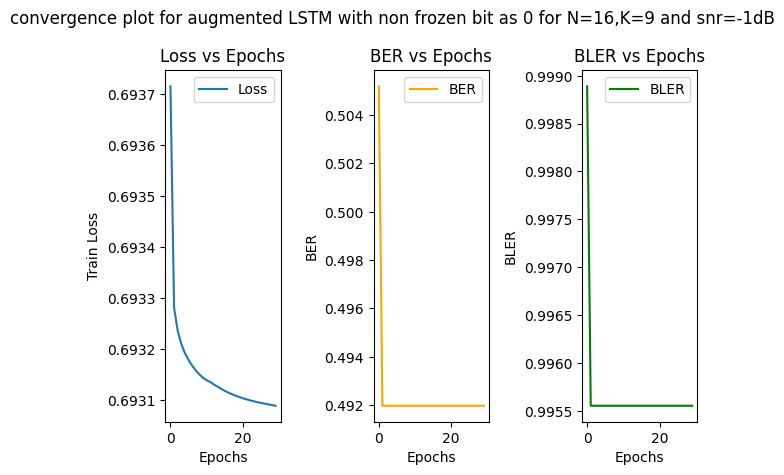

In [11]:
plt.suptitle('convergence plot for augmented LSTM with non frozen bit as 0 for N=16,K=9 and snr=-1dB')
# Plot Loss vs Epochs
plt.subplot(1, 3, 1)
plt.plot(loss_values, label='Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.legend()

# Plot BER vs Epochs
plt.subplot(1, 3, 2)
plt.plot(ber_values, label='BER', color='orange')
plt.title('BER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()

# Plot BLER vs Epochs


plt.subplot(1, 3, 3)
plt.plot(bler_values, label='BLER', color='green')
plt.title('BLER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BLER')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
model.load_state_dict(torch.load(r'C:\Users\pratyush\Desktop\FYP\PolarNet\weights\N_16_K_9_SNR_-1_logic1_nonfrozen_-1\epoch_29.pth'),strict=True)

<All keys matched successfully>

In [ ]:
ber_total,bler_total = 0,0
test_loader = df['msg_bits'][900:]
count = 0
with torch.no_grad():
    model.eval()
    for msg_bits, corrupted_codeword in zip(df['msg_bits'][900:], df['corrupted_codeword'][900:]):
        count += 1
        msg_tensor = torch.tensor(msg_bits, dtype=torch.float32).to(device)
        corrupted_codeword_tensor = torch.tensor(corrupted_codeword, dtype=torch.float32).to(device)

        _,final_predictions = model(corrupted_codeword_tensor)
        if (count%20==0):
            print(f'final_predictions {(final_predictions>=0).float()}')
            print(f'msg_tensor {msg_tensor}')
            if((final_predictions>0).float()==msg_tensor).all():
                print('decoded correctly')
            else:
                print('decoded incorrectly')
            print('----------')
        ber,bler = calculate_ber_bler((final_predictions>=0).float(),msg_tensor)
        ber_total += ber
        bler_total += bler
    avg_ber = ber_total / len(test_loader)
    avg_bler = bler_total / len(test_loader)
    print(f"Test Results - BER: {avg_ber:.4f}, BLER: {avg_bler:.4f}")

final_predictions tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
msg_tensor tensor([[1., 1., 1., 1., 1., 0., 0., 0., 1.]], device='cuda:0')
decoded incorrectly
----------
final_predictions tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
msg_tensor tensor([[0., 1., 0., 1., 1., 1., 1., 1., 0.]], device='cuda:0')
decoded incorrectly
----------
final_predictions tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
msg_tensor tensor([[1., 1., 1., 0., 1., 1., 1., 1., 0.]], device='cuda:0')
decoded incorrectly
----------
final_predictions tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
msg_tensor tensor([[1., 1., 1., 1., 0., 1., 1., 1., 0.]], device='cuda:0')
decoded incorrectly
----------
final_predictions tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
msg_tensor tensor([[0., 1., 1., 1., 1., 1., 0., 0., 0.]], device='cuda:0')
decoded incorrectly
----------
Test Results - BER: 0.4989, BLER: 1.0000


: 